In [1]:
type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

## Solve an inverse tarffic problem over polynomials of degree at most d

## Optionally use a regularizer from the poly kernel

In [2]:
using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	#assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
    @addConstraint(m, coeffs[1] == 1)
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [9]:
############
#Read in the demand file
file = open("../data_original/SiouxFalls_trips.txt")
demands = Dict{(Int64,Int64), Float64}()
s = 0
for line in eachline(file)
    if contains(line, "Origin")
        s = int(split(line)[2])
    else
        pairs = split(line, ";")
        for pair in pairs
            if !contains(pair, "\n")
                pair_vals = split(pair, ":")
                t, demand = int(pair_vals[1]), float(pair_vals[2])
                demands[(s,t)] = demand 
            end
        end
    end
end                
close(file)

In [10]:
############
#read in the arc files
arcs = Dict{(Int, Int), Arc}()
file = open("../data_original/SiouxFalls_net.txt")
inHeader=true
for line in eachline(file)
    if inHeader
        inHeader = !contains(line, "Init node")
        continue
    end
    vals = split(line, )
    arcs[(int(vals[1]), int(vals[2]))] = Arc(int(vals[1]), int(vals[2]), float(vals[3]), float(vals[5]))
end
close(file)

In [11]:
###########
#read in the initial flows
file = open("../data_original/SiouxFallsFlow.txt")
ix = 0; 
for line in eachline(file)
    ix +=1
    if ix ==1
        continue
    end
    vals = split(line)
    arcs[(int(vals[1]), int(vals[2]))].flow = float(vals[3])
end
close(file)

In [12]:
##########
# Set up demand data and flow data
##########

flow_data = Array(Float64, length(arcs))
demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs)
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end

for odpair in keys(demands)
    if ! haskey(demand_data, odpair)
        demand_data[odpair] = [demands[odpair], ]
    else
        push!(demand_data[odpair], demands[odpair])
    end
end

flow_data = [a.flow::Float64 for a in vArcs]

76-element Array{Float64,1}:
 19083.3 
  6302.02
  7000.0 
  9626.21
 17726.6 
  6882.66
 12378.6 
 10259.5 
  8094.66
  9941.86
 18006.4 
 11683.8 
  7000.0 
     ⋮   
  9973.71
 15854.6 
 17604.2 
 18409.9 
  5991.76
 12040.9 
  8394.9 
 18976.8 
 15278.3 
 10022.3 
 15794.0 
 15796.7 

In [13]:
##########
#Fitting Funcs
##########

function train(lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    

    #copy the flow data over to the arcs, demand data to demands (slow)
    for (ix, a) in enumerate(vArcs)
        a.flow = flow_data[ix]
    end
    for odpair in keys(demands)
        demands[odpair] = demand_data[odpair][1]
    end

    #Dual Feasibility
    ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)

    #add the residual for this data point
    push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))


    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    return [getValue(coeffs[i]) for i =1:length(coeffs)], getValue(ys)
end

train (generic function with 1 method)

In [14]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 576 entries:
  (23,8)  => [300.0]
  (8,23)  => [300.0]
  (6,9)   => [400.0]
  (18,3)  => [0.0]
  (21,13) => [600.0]
  (22,16) => [1200.0]
  (15,17) => [1500.0]
  (22,14) => [1200.0]
  (13,9)  => [600.0]
  (23,10) => [1800.0]
  (24,22) => [1100.0]
  (8,9)   => [800.0]
  (9,1)   => [500.0]
  (17,14) => [700.0]
  (16,6)  => [900.0]
  (16,12) => [700.0]
  (16,13) => [600.0]
  (22,2)  => [100.0]
  (24,3)  => [0.0]
  (7,16)  => [1400.0]
  (1,12)  => [200.0]
  (4,5)   => [500.0]
  (11,8)  => [800.0]
  (18,21) => [100.0]
  (19,4)  => [200.0]
  ⋮       => ⋮

In [15]:
#include("trafficCval.jl")

coeffs_dict = Dict{(Int64,Float64,Float64),Array{Float64,1}}()

deg = 6
c = 3.41
lam = 1.

fcoeffs, ys = train(lam, deg, c, demand_data, flow_data, arcs)
coeffs_dict[(deg, c, lam)] = fcoeffs

7-element Array{Float64,1}:
  1.0       
  0.0166628 
 -0.0602106 
  0.0825853 
  0.0956753 
  0.0172241 
 -0.00211285

In [16]:
ys

ys: 2 dimensions, 13824 entries:
 [  (1,1), 1] = -0.06827714813349244
 [  (1,1), 2] = -0.06458879519522158
 [  (1,1), 3] = -0.06605326661240683
 [  (1,1), 4] = -0.0434792900382607
 [  (1,1), 5] = -0.043396279117570165
 [  (1,1), 6] = -0.05018921615522036
 [  (1,1), 7] = -0.00351047414798518
 [  (1,1), 8] = -0.0007381161092811315
 [  (1,1), 9] = -0.026479467459873965
 [  (1,1),10] = -0.03806148134374138
 [  (1,1),11] = -0.024062464289858497
 [  (1,1),12] = -0.0705786975980825
 [  (1,1),13] = -0.0704767156329176
 [  (1,1),14] = 0.00014572154785816096
 [  (1,1),15] = -0.02285872801120158
 [  (1,1),16] = -0.009814495555516197
 [  (1,1),17] = -0.01803032482135323
 [  (1,1),18] = -0.004961879489954718
 [  (1,1),19] = -0.017694772804810417
 [  (1,1),20] = -0.01470937977869257
 [  (1,1),21] = -0.003147355687324
 [  (1,1),22] = 0.0
 [  (1,1),23] = 0.0252298279048689
 [  (1,1),24] = 0.04287897161007184
 [  (1,2), 1] = -1.7913456196493276
 [  (1,2), 2] = 4.2172184895173785
 [  (1,2), 3] = -1.4105

INFO: Loading help data...


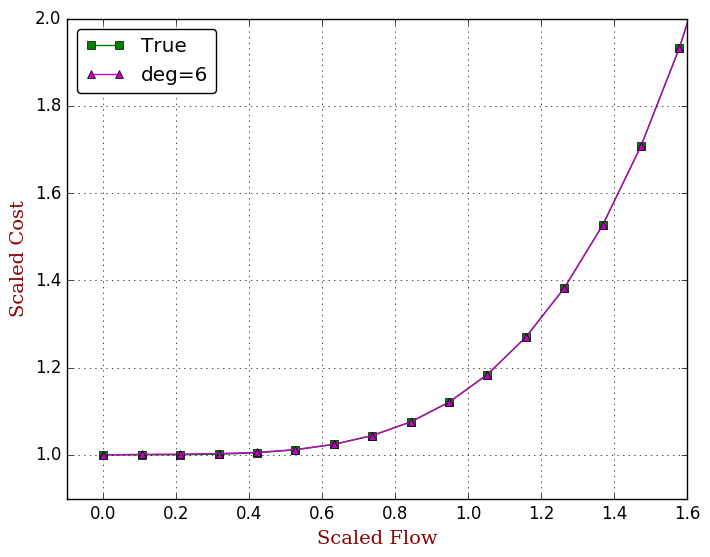

In [17]:
using PyPlot

true_coeffs = [1, 0, 0, 0, .15]

fcoeffs = coeffs_dict[(6, 3.41, 1.)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(fcoeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("fitting_Sioux.pdf")